# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle  


______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()  
- Prepare data: prepare.prep_store_data()  
- Split data: prepare.split_store_data()  

Then we will forecast and evaluate using each method. 

## Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime 
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
# %matplotlib inline 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

## Acquire

We will acquire the store-item-demand data for this lesson from the sql database. 

In [3]:
# define get_connection
def get_connect(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [4]:
# assign query to variable 
query = '''SELECT stores.*, items.*, sales.sale_date, sales.sale_amount  
            FROM sales 
            JOIN stores USING(store_id)   
            JOIN items USING(item_id);'''

In [5]:
# read sql query using pd.read_sql()
df = pd.read_sql(query, get_connect('tsa_item_demand'))

In [6]:
# take a peek
df.head()

,store_id,store_address,store_zipcode,store_city,store_state,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_date,sale_amount
0,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-01,13
1,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-02,11
2,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-03,14
3,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-04,13
4,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-05,10


## Prepare


1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!

In [7]:
# sale_date to datetime
df = df.assign(ds = pd.to_datetime(df.sale_date))

In [8]:
# set index
df = df.sort_values('ds')

In [9]:
# create dollars_sold = sale_amount * item_price
df = df.assign(dollars_sold = df.sale_amount * df.item_price)

In [10]:
# create items_sold from sale_amount (rename)
df = df.assign(items_sold = df.sale_amount)

In [11]:
# resample daily, summing dollars_sold and items_sold
df = df.groupby(['ds'])[['dollars_sold', 'items_sold']].sum()

In [19]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


In [90]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum()

In [91]:
df = prep_data(df)


AttributeError: 'DataFrame' object has no attribute 'sale_date'

In [92]:
df = df[df.index != '2016-02-29']

In [93]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [23]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)
train_size

913

In [24]:
# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)
validate_size

547

In [25]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [26]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

1460

In [27]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [ ]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

Does the first row of original df equate to the first row of train? 

In [ ]:
# test the row starts
print(df.head(1) == train.head(1))

Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [ ]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])

In [ ]:
pd.concat([validate.tail(1), test.head(1)])

Is the last row of test the same as the last row of our original dataframe? 

In [ ]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

Let's plot our data first, viewing where the data is split into train, validate, and test. 

In [28]:
train.columns

Index(['dollars_sold', 'items_sold'], dtype='object')

In [29]:
# plot the data points, color by train, validate, test
col = "dollars_sold"
def plot_samples(target_var):
    '''
    this function will plot the train, validate, and train values for a single variables across all dates.
    '''
    plt.figure(figsize = (12, 4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.title(col)
    plt.show()

In [ ]:
for col in train.columns:
    plot_samples(col)

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [55]:
# define evaluation function to compute rmse
def evaluate(target_var):
    '''
    the evaluate function will take in the acutal values in validate and the predicted values 
    and compute the mean_squared_error and then take the square root and round to 0 decimals.
    I will return the rmse, as an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [31]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    
    plt.plot(yhat_df[target_var])
    
    plt.title(target_var)
    
    rmse = evaluate(target_var)
    
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [59]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [60]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [61]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model type as a string, 
    the target variable as a string, 
    and run the evaluate function to compute the rmse, 
    and append to the dataframe a row with the model type, target variable, and rmse. 
    It will return a new dataframe.
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecast 

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

In [35]:
# create var 'items' with last observed value
items = train['items_sold'][-1]
items

33134

In [36]:
dollars = round(train['dollars_sold'][-1], 2)
dollars

178036.64

In [37]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = validate.index)

In [38]:
yhat_df.head()

,items_sold,dollars_sold
ds,,
2015-07-03,33134,178036.64
2015-07-04,33134,178036.64
2015-07-05,33134,178036.64
2015-07-06,33134,178036.64
2015-07-07,33134,178036.64


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

In [39]:
train

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237
...,...,...
2015-06-28,201002.82,37410
2015-06-29,134932.08,25074
2015-06-30,158904.06,29345


dollars_sold -- RMSE: 35402


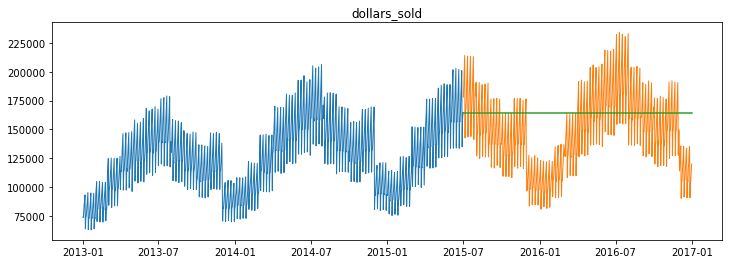

items_sold -- RMSE: 6621


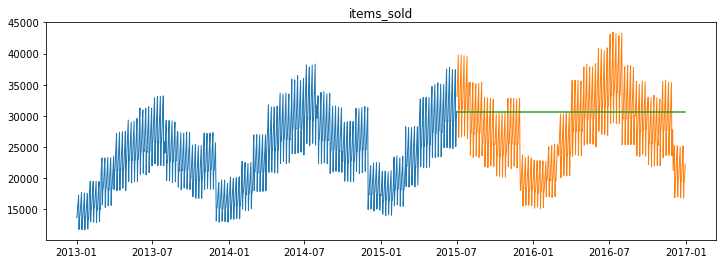

In [163]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [57]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [58]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,33802.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

In [41]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [42]:
yhat_df

,items_sold,dollars_sold
ds,,
2015-07-03,23728.25,127573.19
2015-07-04,23728.25,127573.19
2015-07-05,23728.25,127573.19
2015-07-06,23728.25,127573.19
2015-07-07,23728.25,127573.19
...,...,...
2016-12-26,23728.25,127573.19
2016-12-27,23728.25,127573.19
2016-12-28,23728.25,127573.19


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

dollars_sold -- RMSE: 39664


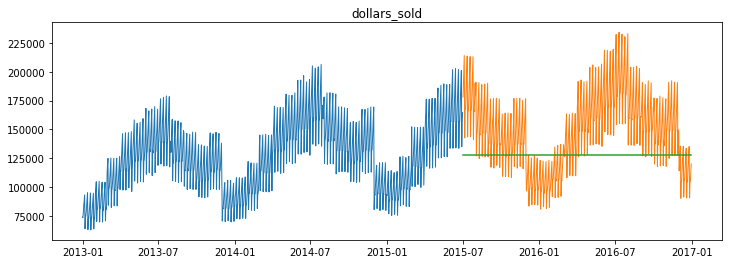

items_sold -- RMSE: 7378


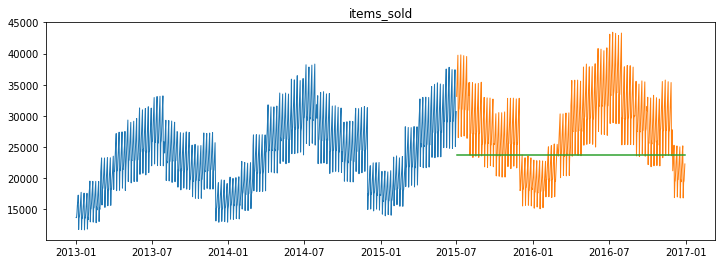

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

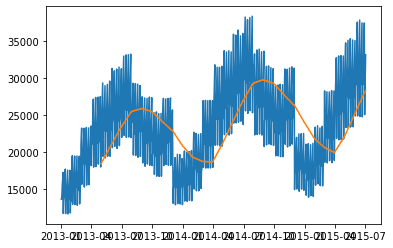

In [43]:
plt.plot(train['items_sold'])
plt.plot(train['items_sold'].rolling(120).mean())

In [165]:
period = 30 
items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

dollars_sold -- RMSE: 37378


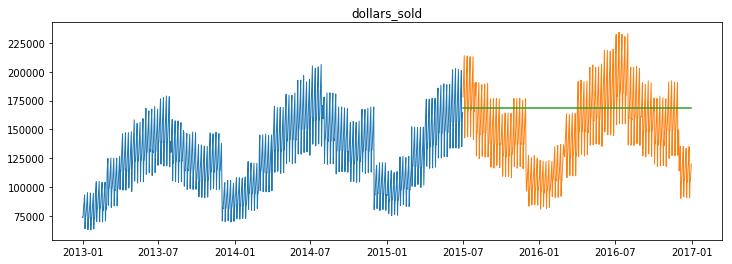

items_sold -- RMSE: 6954


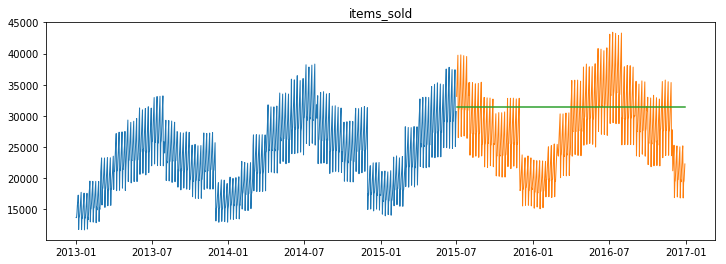

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [46]:
period = 60

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-03,30481.17,163938.07
2015-07-04,30481.17,163938.07
2015-07-05,30481.17,163938.07


Let's try out several other values for periods:

In [47]:
period = 365

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-03,25548.7,137347.16
2015-07-04,25548.7,137347.16
2015-07-05,25548.7,137347.16


In [48]:
period = 90

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-03,29669.14,159488.39
2015-07-04,29669.14,159488.39
2015-07-05,29669.14,159488.39


In [51]:
train.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


In [62]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [64]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).median().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).median().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving median'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [65]:
eval_df

,model_type,target_var,rmse
0,1d moving average,items_sold,7970.0
1,1d moving average,dollars_sold,42791.0
2,4d moving average,items_sold,6259.0
3,4d moving average,dollars_sold,33701.0
4,12d moving average,items_sold,6928.0
5,12d moving average,dollars_sold,37291.0
6,26d moving average,items_sold,6989.0
7,26d moving average,dollars_sold,37569.0
8,52d moving average,items_sold,6666.0
9,52d moving average,dollars_sold,35873.0


Which is best so far? 

In [ ]:
# get the min rmse for each variable

In [10]:
# filter only the rows that match those rmse to find out 
# which models are best thus far


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

dollars_sold 



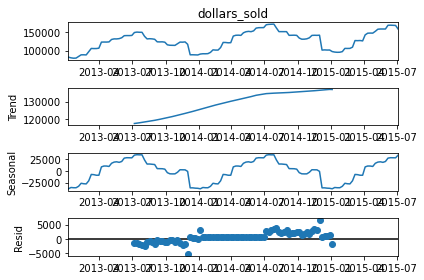

items_sold 



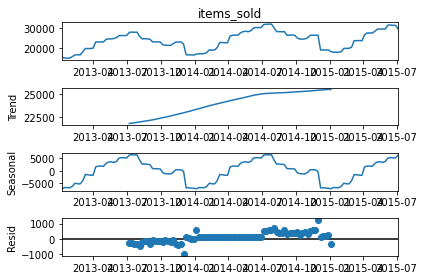

In [66]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

In [82]:
for col in train.columns:
    model = Holt(train['items_sold'], exponential = False)

    #fit the model providing the alpha/smoothing level and beta/smoothing level
    model = model.fit(
                smoothing_level = .5, 
                 smoothing_slope = .5, 
                 optimized = False
                 )

    #predict/forecast providing start and end date
    yhat= model.predict(start = validate.index[0], end = validate.index[-1])

    yhat_df[col] = round(yhat, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [83]:
yhat_df.head()

,items_sold,dollars_sold
ds,,
2015-07-03,31081.73,31081.73
2015-07-04,31268.80,31268.80
2015-07-05,31455.86,31455.86
2015-07-06,31642.93,31642.93
2015-07-07,31829.99,31829.99


**Plot Actual vs. Predicted Values**

dollars_sold -- RMSE: 79764


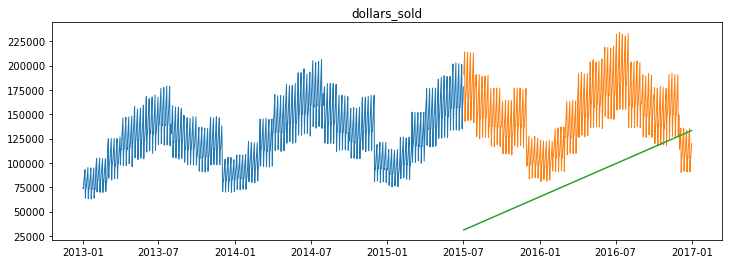

items_sold -- RMSE: 61732


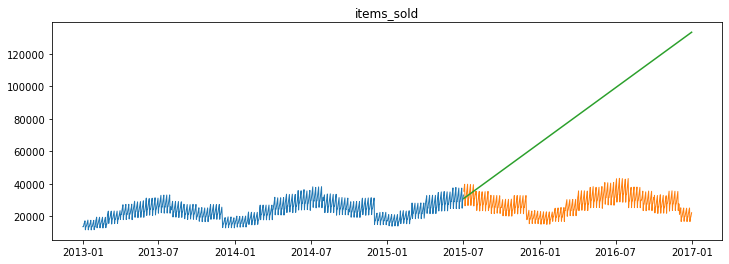

In [84]:
for col in train.columns:
    eval_df = append_eval_df(model_type = "Holts", target_var = col)
    plot_and_eval(target_var = col)

**Evaluate**

In [85]:
eval_df

,model_type,target_var,rmse
0,1d moving average,items_sold,7970.0
1,1d moving average,dollars_sold,42791.0
2,4d moving average,items_sold,6259.0
3,4d moving average,dollars_sold,33701.0
4,12d moving average,items_sold,6928.0
5,12d moving average,dollars_sold,37291.0
6,26d moving average,items_sold,6989.0
7,26d moving average,dollars_sold,37569.0
8,52d moving average,items_sold,6666.0
9,52d moving average,dollars_sold,35873.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [94]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

**Make Predictions**

In [95]:
yhat_df = train['2015'] + train.diff(365).mean()

In [96]:
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-01-01,104337.620493,19411.813699
2016-01-01,107875.260000,20158.000000


In [97]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

**Plot and Evaluate**

dollars_sold -- RMSE: 28087


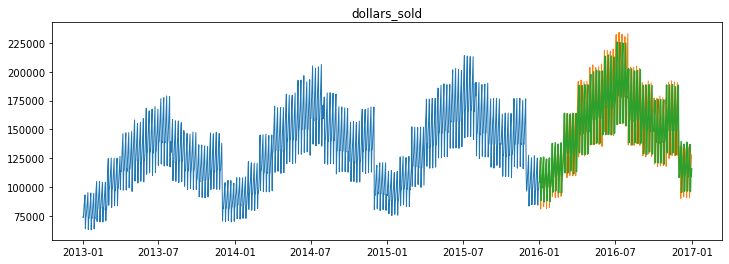

items_sold -- RMSE: 5223


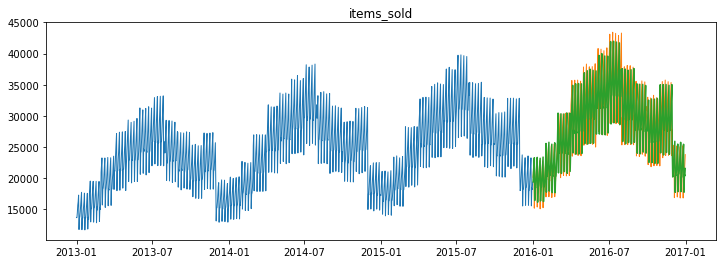

In [98]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

## Conclusion

Which model did the best? 

In [99]:
# get the min rmse for each variable
min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
26,previous year,dollars_sold,28087.0
27,previous year,items_sold,5223.0


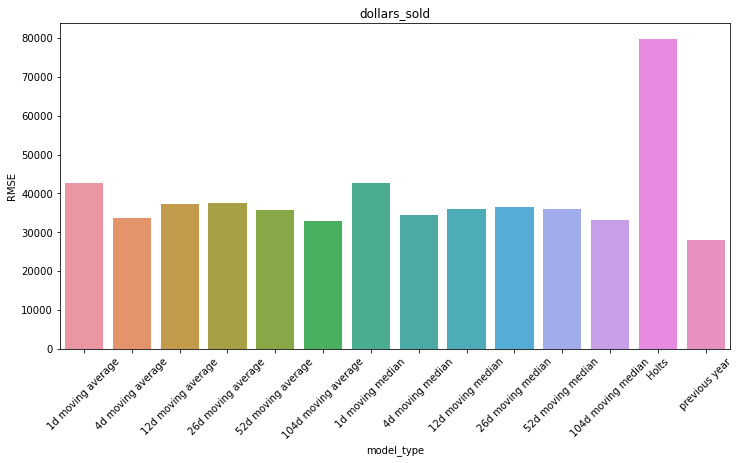

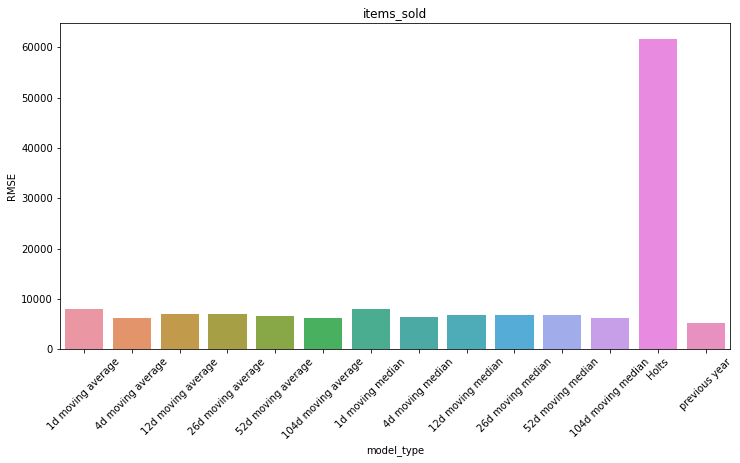

In [100]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.